# Goals:
1.	Development of POC Semantic Chunker:
	•	Algorithm Basis: Inspired by advice from the Pinecone advisor.
	•	Chunking Method: Start with sentence. Use chunk extension rule to get 'next sentence'. Combine if similarity is in threshold. Repeat this process to keep extend chunk until one breaks. 
	•	Chunk Extension Rule: Add a maximum of 50 tokens, using RecursiveSplitter for precise breaks:
	  •	Full Stop: Preferred splitting point within 50 tokens.
	  •	Comma: Next preferred splitting point within 50 tokens.
	•	Goal: Ensure chunks remain under 500 tokens and aren't tripped by messy strings.


Important thoughts:
"Jack bought a super fast car." "It was bright red.". These two sentences have a low similarity however they clearly connect. How could we capture this? Logits would do that.

In [1]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

import os
from openai import OpenAI
import numpy as np

class SemanticChunker():
    def __init__(self, max_chunk_size=400, min_chunk_size=50, BERT=False):
        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=min_chunk_size,
            chunk_overlap=0,
            length_function=num_tokens_from_string
            )
        
        self.max_cluster = max_chunk_size//min_chunk_size
        
    def _get_similarity_matrix(self, sentences):

        OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
        client = OpenAI(api_key=OPENAI_API_KEY)

        response = client.embeddings.create(
            input=sentences,
            model="text-embedding-3-large"
        )

        N = len(sentences)
        embedding_matrix = np.zeros((N, len(response.data[0].embedding)))

        # Populate the embedding matrix
        for i, embedding_obj in enumerate(response.data):
            embedding = np.array(embedding_obj.embedding)
            embedding_matrix[i] = embedding

        similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)

        return similarity_matrix

    def calculate_reward(self, matrix, start, end):
        sub_matrix = matrix[start:end+1, start:end+1]
        return np.sum(sub_matrix)

    # def calculate_local_density(self, matrix, i, window_size=3):
    #     n = matrix.shape[0]
    #     half_window = window_size // 2
    #     start_i = max(0, i - half_window)
    #     end_i = min(n, i + half_window + 1)
    #     local_area = matrix[start_i:end_i, start_i:end_i]
    #     return np.mean(local_area)

    def _optimal_segmentation(self, matrix, max_cluster_size, window_size=3):
        mean_value = np.mean(matrix[np.triu_indices(matrix.shape[0], k=1)])
        matrix = matrix - mean_value  # Normalize the matrix
        np.fill_diagonal(matrix, 0)  # Set diagonal to 1 to avoid trivial solutions

        n = matrix.shape[0]
        dp = np.zeros(n)
        segmentation = np.zeros(n, dtype=int)

        for i in range(n):
            for size in range(1, max_cluster_size + 1):
                if i - size + 1 >= 0:
                    # local_density = calculate_local_density(matrix, i, window_size)
                    reward = self.calculate_reward(matrix, i - size + 1, i)
                    # Adjust reward based on local density
                    adjusted_reward = reward
                    if i - size >= 0:
                        adjusted_reward += dp[i - size]
                    if adjusted_reward > dp[i]:
                        dp[i] = adjusted_reward
                        segmentation[i] = i - size + 1

        clusters = []
        i = n - 1
        while i >= 0:
            start = segmentation[i]
            clusters.append((start, i))
            i = start - 1

        clusters.reverse()
        return clusters
        

    def split_text(self, text):
        sentences = self.splitter.split_text(text)

        similarity_matrix = self._get_similarity_matrix(sentences)

        clusters = self._optimal_segmentation(similarity_matrix, max_cluster_size=self.max_cluster)

        docs = [''.join(sentences[start:end+1]) for start, end in clusters]

        return docs

In [2]:
with open('../data/wikitexts.md', 'r') as file:
    corpus = file.read()

In [3]:
splitter = SemanticChunker()

docs = splitter.split_text(corpus)

KeyboardInterrupt: 

In [117]:
splitter.max_cluster

8

In [4]:
min_chunk_size = 50
splitter = RecursiveCharacterTextSplitter(
    chunk_size=min_chunk_size,
    chunk_overlap=0,
    length_function=num_tokens_from_string
    )

In [5]:
docs = splitter.split_text(corpus)
print(docs[3])
print(len(docs))

. Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan
661


In [6]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.embeddings.create(
    input=docs,
    model="text-embedding-3-large"
)

In [7]:
# Initialize an embedding matrix
N = len(docs)
embedding_matrix = np.zeros((N, len(response.data[0].embedding)))

# Populate the embedding matrix
for i, embedding_obj in enumerate(response.data):
    embedding = np.array(embedding_obj.embedding)
    embedding_matrix[i] = embedding

In [8]:
docs[1]

'Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as'

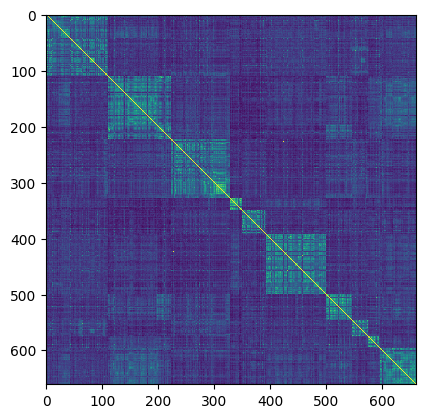

In [9]:
import matplotlib.pyplot as plt

# Compute the dot product of all vectors via matrix multiplication
dot_product_matrix = np.dot(embedding_matrix, embedding_matrix.T)

# Print the matrix using matplotlib
plt.imshow(dot_product_matrix, interpolation='nearest')
plt.colorbar(label='Dot Product Value')
plt.title('Dot Product Matrix')
plt.show()


In [52]:
dot_product_matrix.max()

1.0000001932623812

Cluster boundaries (inclusive): [(0, 7), (8, 9), (10, 17), (18, 25), (26, 26), (27, 34), (35, 42), (43, 48), (49, 56), (57, 64), (65, 72), (73, 79), (80, 87), (88, 93), (94, 101), (102, 109), (110, 115), (116, 123), (124, 131), (132, 139), (140, 140), (141, 148), (149, 153), (154, 161), (162, 169), (170, 177), (178, 178), (179, 186), (187, 194), (195, 202), (203, 210), (211, 211), (212, 219), (220, 223), (224, 231), (232, 232), (233, 240), (241, 241), (242, 249), (250, 251), (252, 259), (260, 266), (267, 274), (275, 282), (283, 290), (291, 298), (299, 303), (304, 311), (312, 319), (320, 327), (328, 335), (336, 343), (344, 349), (350, 357), (358, 365), (366, 366), (367, 374), (375, 382), (383, 383), (384, 391), (392, 392), (393, 400), (401, 408), (409, 415), (416, 423), (424, 424), (425, 431), (432, 439), (440, 441), (442, 449), (450, 457), (458, 458), (459, 466), (467, 474), (475, 478), (479, 486), (487, 493), (494, 499), (500, 500), (501, 508), (509, 513), (514, 521), (522, 522), (523

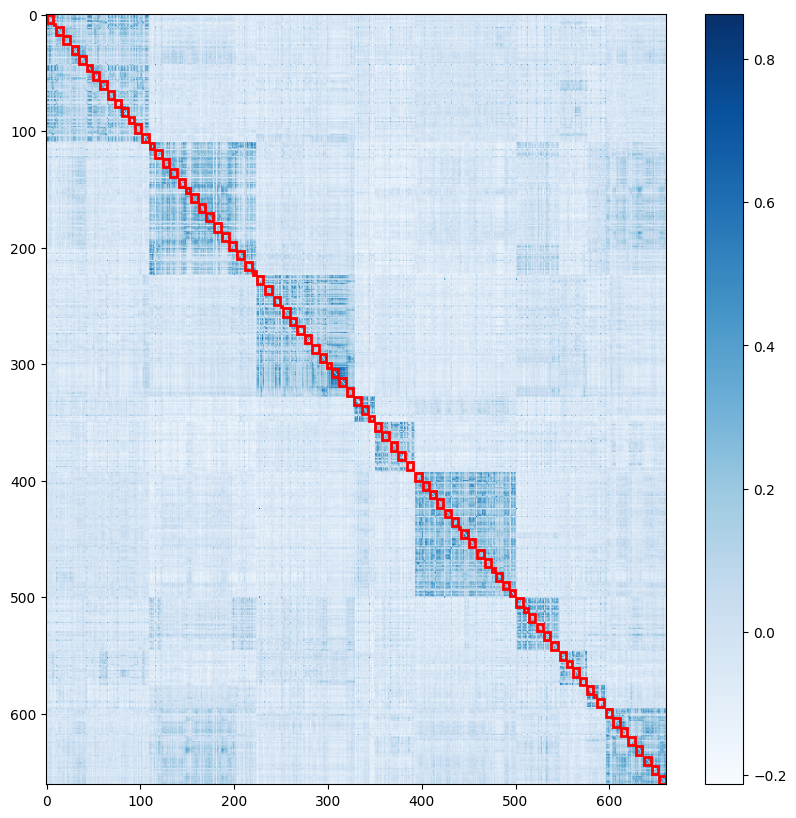

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_reward(matrix, start, end):
    sub_matrix = matrix[start:end+1, start:end+1]
    return np.sum(sub_matrix)

def calculate_local_density(matrix, i, window_size=3):
    n = matrix.shape[0]
    half_window = window_size // 2
    start_i = max(0, i - half_window)
    end_i = min(n, i + half_window + 1)
    local_area = matrix[start_i:end_i, start_i:end_i]
    return np.mean(local_area)

def optimal_segmentation(matrix, max_cluster_size, window_size=3):
    similarity_matrix = matrix.copy()

    

    n = matrix.shape[0]
    dp = np.zeros(n)
    segmentation = np.zeros(n, dtype=int)

    for i in range(n):
        for size in range(1, max_cluster_size + 1):
            if i - size + 1 >= 0:
                local_density = calculate_local_density(matrix, i, window_size)
                reward = calculate_reward(matrix, i - size + 1, i)
                # Adjust reward based on local density
                adjusted_reward = reward
                if i - size >= 0:
                    adjusted_reward += dp[i - size]
                if adjusted_reward > dp[i]:
                    dp[i] = adjusted_reward
                    segmentation[i] = i - size + 1

    clusters = []
    i = n - 1
    while i >= 0:
        start = segmentation[i]
        clusters.append((start, i))
        i = start - 1

    clusters.reverse()
    return clusters



# Example usage:
similarity_matrix = dot_product_matrix.copy() # Replace with your similarity matrix
mean_value = np.mean(similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=1)])

similarity_matrix = similarity_matrix - mean_value  # Normalize the matrix

np.fill_diagonal(similarity_matrix, 0)  # Set diagonal to 1 to avoid trivial solutions

max_cluster_size = 8  # Define the maximum cluster size

clusters = optimal_segmentation(similarity_matrix, max_cluster_size, 3)
print("Cluster boundaries (inclusive):", clusters)

# Visualize the segmented matrix
order = np.concatenate([np.arange(start, end + 1) for start, end in clusters])
ordered_matrix = similarity_matrix[order, :][:, order]

plt.figure(figsize=(10, 10))
plt.imshow(ordered_matrix, aspect='auto', cmap='Blues')
plt.colorbar()

# Draw clusters as red squares
for start, end in clusters:
    plt.gca().add_patch(plt.Rectangle((start, start), end-start, end-start, fill=False, edgecolor='red', linewidth=2))

plt.show()

In [105]:
print(len(clusters))

cluster_sizes = [end - start + 1 for start, end in clusters]
average_cluster_size = sum(cluster_sizes) / len(cluster_sizes)
min_cluster_size = min(cluster_sizes)
max_cluster_size = max(cluster_sizes)
std_cluster_size = np.std(cluster_sizes)

print("Average cluster size:", average_cluster_size)
print("Min cluster size:", min_cluster_size)
print("Max cluster size:", max_cluster_size)
print("Standard deviation of cluster size:", std_cluster_size)


104
Average cluster size: 6.355769230769231
Min cluster size: 1
Max cluster size: 8
Standard deviation of cluster size: 2.6418170801944445


In [106]:
# def generate_sequence(start_end_tuple):
#     start, end = start_end_tuple
#     return list(range(start, end + 1))

split_docs = [''.join(docs[start:end+1]) for start, end in clusters]


In [109]:
split_docs[5]

'The game takes place during the Second Europan War . Gallian Army Squad 422 , also known as " The Nameless " , are a penal military unit composed of criminals , foreign deserters , and military offenders whose real names are erased fromthe records and thereon officially referred to by numbers . Ordered by the Gallian military to perform the most dangerous missions that the Regular Army and Militia will not do , they are nevertheless up to the task , exemplified by their motto ,<unk> <unk> , meaning " Always Ready . " The three main characters are No.7 Kurt Irving , an army officer falsely accused of treason who wishes to redeem himself ; Ace No.1 Imca , a female Darcsen heavyweapons specialist who seeks revenge against the Valkyria who destroyed her home ; and No.13 Riela <unk> , a seemingly jinxed young woman who is unknowingly a descendant of the Valkyria . Together with their fellow squad members, these three are tasked to fight against a mysterious Imperial unit known as Calamity 

In [118]:
tokens = []

for doc in docs:
    tokens.append(num_tokens_from_string(doc))

import statistics

print("Mean of tokens:", statistics.mean(tokens))
print("Median of tokens:", statistics.median(tokens))
print("Min of tokens:", min(tokens))
print("Max of tokens:", max(tokens))


Mean of tokens: 254.08653846153845
Median of tokens: 301.5
Min of tokens: 1
Max of tokens: 401
